In [ ]:
# General Imports
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.utils import plot_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
# Creating a Ticker object for NVIDIA stock with symbol "NVDA"
ticker = 'NVDA'
df = yf.download(ticker, start="2017-01-01", end="2023-12-14")
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,26.100000,26.592501,24.844999,25.502501,25.136072,150199600
2017-01-04,25.850000,26.375000,25.382500,26.097500,25.722523,119922000
2017-01-05,26.132500,26.455000,25.262501,25.434999,25.069542,98429600
2017-01-06,25.712500,26.062500,25.299999,25.775000,25.404654,82285600
2017-01-09,25.875000,27.000000,25.875000,26.820000,26.434637,91624800
...,...,...,...,...,...,...
2023-12-07,457.000000,466.290009,456.040009,465.959991,465.959991,35082300
2023-12-08,465.950012,477.410004,465.500000,475.059998,475.059998,35880300
2023-12-11,474.910004,475.309998,458.299988,466.269989,466.269989,50972800


In [ ]:
# Resample data to business days,filling missing values with previous day
data = df[['Close']].asfreq('B').fillna(method='ffill')
# Resetting the index of the dataframe
data = data.reset_index()

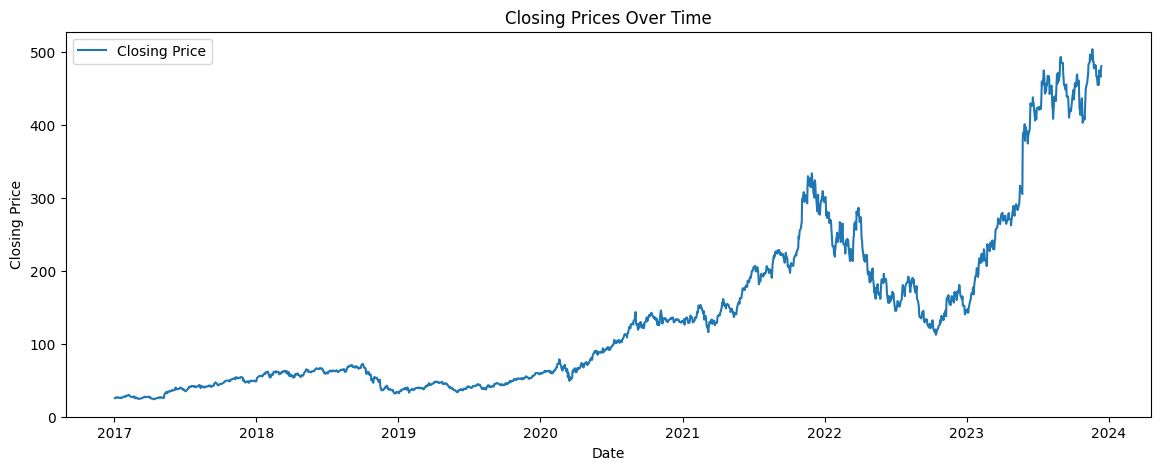

In [ ]:
# Plotting closing prices over time
plt.figure(figsize=(14, 5))
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.savefig('figure1.png')
plt.show()

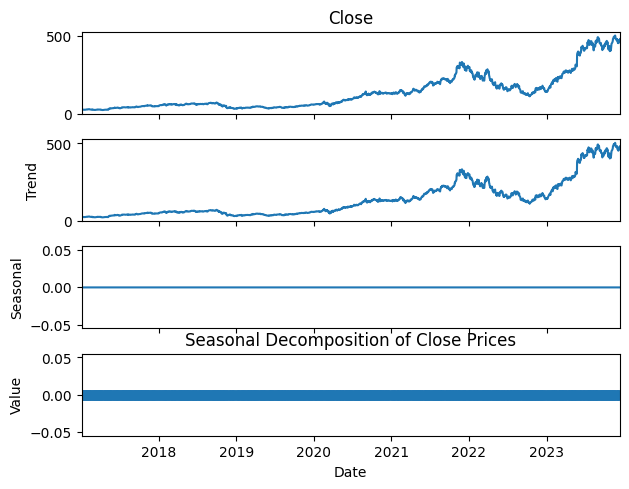

In [ ]:
# Decomposing time series for seasonality check
result = seasonal_decompose(df['Close'], model='additive', period=1)
result.plot()
plt.title('Seasonal Decomposition of Close Prices')
plt.xlabel('Date')
plt.ylabel('Value')
plt.savefig('figure2.png')
plt.show()

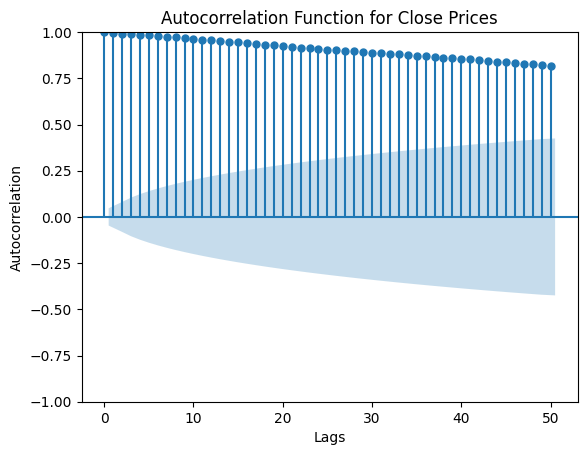

In [ ]:
# Plot autocorrelation function for Close data
plot_acf(df['Close'], lags = 50)
plt.title('Autocorrelation Function for Close Prices')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.savefig('figure3.png')
plt.show()

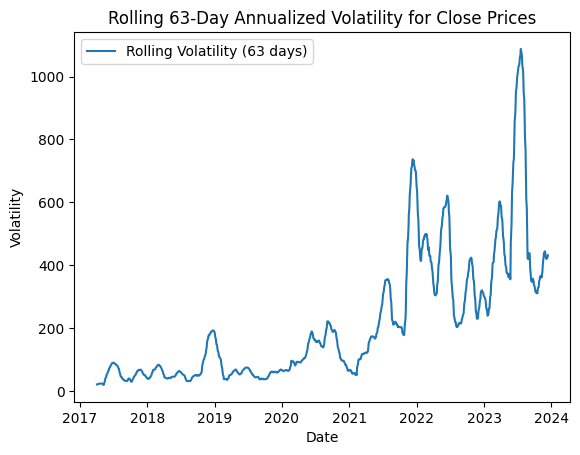

In [ ]:
# Calculate rolling 63 day annualized volatility for Close as total traiding days in a year is 252
roll_vol = df['Close'].rolling(63).std() * np.sqrt(252)
# Plotting rolling volatility
plt.plot(roll_vol, label='Rolling Volatility (63 days)')
plt.title('Rolling 63-Day Annualized Volatility for Close Prices')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.savefig('roll_vol_plot.png')
plt.show()


In [ ]:
# Perform Augmented Dickey-Fuller test on Close data
result = adfuller(df['Close'])
print('ADF Statistic:', result[0]) # Print ADF Statistic
print('p-value:', result[1]) # Print p-value
print('Critical Values:', result[4]) # Print Critical Values

ADF Statistic: 1.4409976138554843
p-value: 0.9972926566550709
Critical Values: {'1%': -3.434133375964546, '5%': -2.8632111492477503, '10%': -2.5676596723058402}


In [ ]:
# Scale Close data with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))
# Defining look-back period and split data into train/test data
look_back = 80
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]
# Creating time series generatord for training and testing data
train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)



In [ ]:
# Defining LSTM model architecture
lstm_model = Sequential()
# Add LSTM layer with 100 units
lstm_model.add(LSTM(units=100, return_sequences=True,
                    input_shape=(look_back, 1)))
# Add dropout regularization
lstm_model.add(Dropout(0.2))
# Add LSTM layer with 100 units
lstm_model.add(LSTM(units=100,return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dropout(0.2))
# Add Dense output layer with 1 unit
lstm_model.add(Dense(1))
# Compile model using Adam optimizer and MSE loss
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=61 )

Epoch 1/61
66/66 [==============================] - 18s 162ms/step - loss: 0.0078
Epoch 2/61
66/66 [==============================] - 11s 174ms/step - loss: 0.0021
Epoch 3/61
66/66 [==============================] - 11s 173ms/step - loss: 0.0015
Epoch 4/61
66/66 [==============================] - 11s 167ms/step - loss: 0.0011
Epoch 5/61
66/66 [==============================] - 12s 173ms/step - loss: 0.0021
Epoch 6/61
66/66 [==============================] - 12s 181ms/step - loss: 0.0012
Epoch 7/61
66/66 [==============================] - 13s 196ms/step - loss: 7.2609e-04
Epoch 8/61
66/66 [==============================] - 11s 173ms/step - loss: 0.0013
Epoch 9/61
66/66 [==============================] - 12s 177ms/step - loss: 0.0012
Epoch 10/61
66/66 [==============================] - 12s 175ms/step - loss: 0.0023
Epoch 11/61
66/66 [==============================] - 11s 167ms/step - loss: 0.0012
Epoch 12/61
66/66 [==============================] - 12s 178ms/step - loss: 5.7808e-04
Epoch

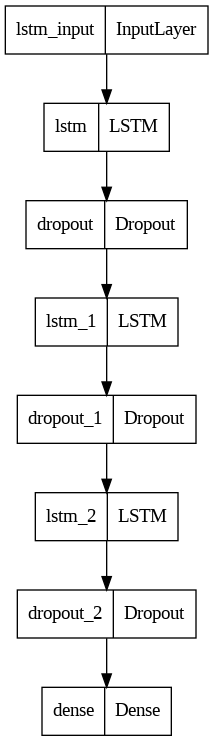

In [ ]:
# Visualizing architecture of LSTM model using plot_model function
plot_model(lstm_model)

In [ ]:
# Generating predictions on test data using LSTM model
lstm_predictions = lstm_model.predict(test_generator)
# Rescaling LSTM predictions to original values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
# Converting portion of test data back to its original scale
actual_prices = scaler.inverse_transform(test_data[look_back:])


350/350 [==============================] - 17s 46ms/step


In [ ]:
# Calculating lengths of actual and predicted price arrays
length_actual = len(actual_prices)
length_predicted = len(lstm_predictions)

print("Length of Actual Monthly Return:", length_actual)
print("Length of Predicted Monthly Return:", length_predicted)

Length of Actual Monthly Return: 350
Length of Predicted Monthly Return: 350


In [ ]:
# Calculating Mean Squared Error, Mean Absolute Error and R-squared
mse = mean_squared_error(actual_prices, lstm_predictions)
mae = mean_absolute_error(actual_prices, lstm_predictions)
r2 = r2_score(actual_prices, lstm_predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 150.514846137319
Mean Absolute Error (MAE): 9.305176348005022
R-squared (R2): 0.9912942616602257


In [ ]:
# Calculating Root Mean Squared Error
rmse = np.sqrt(np.mean(lstm_predictions - actual_prices) ** 2)
print("Root Mean Squared Error :", rmse)

0.15148376464843816


In [ ]:
# Calculating Mean Absolute Percentage Error
mape = np.mean(np.abs((actual_prices - lstm_predictions) / actual_prices)) * 100
# Computing predictions within 1% range of actual prices
within_1_percent = np.sum(np.abs((actual_prices - lstm_predictions) / actual_prices) <= 0.01) / len(actual_prices) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Percentage of Predictions Within 1% Range: {within_1_percent:.2f}%")

Mean Absolute Percentage Error (MAPE): 3.60%
Percentage of Predictions Within 1% Range: 21.14%


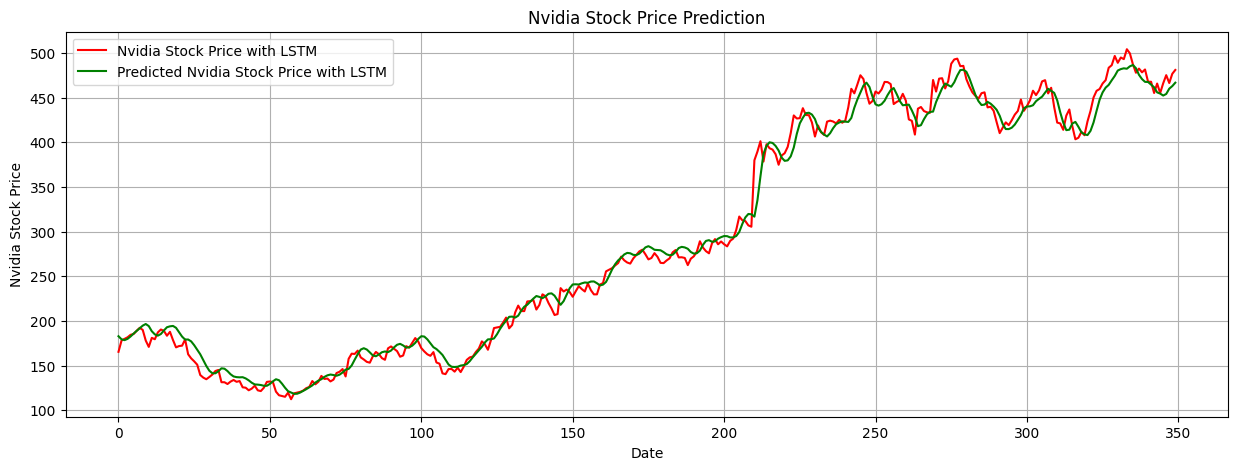

In [ ]:
# Visualizing actual and predicted Nvidia stock prices using LSTM
plt.figure(figsize=(15,5))
plt.plot(actual_prices, color='red', label='Nvidia Stock Price with LSTM')
plt.plot(lstm_predictions, color='green', label='Predicted Nvidia Stock Price with LSTM')
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Nvidia Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('figure Prediction.png')
plt.show()

In [ ]:
def predict_future_days(model, base_data, days_to_predict, scaler, look_back=2000):
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction
        prediction = model.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions


In [ ]:
# Predicting Nvidia stock prices for next 180 days using LSTM
days_to_predict = 180
future_days = predict_future_days(lstm_model, scaled_data, days_to_predict, scaler, look_back)

1/1 [==============================] - 0s 64ms/step


In [ ]:
print(future_days)

[[470.85272]
 [470.41968]
 [467.84058]
 [464.3103 ]
 [460.3957 ]
 [456.38232]
 [452.4517 ]
 [448.7333 ]
 [445.31573]
 [442.2512 ]
 [439.56027]
 [437.23782]
 [435.2595 ]
 [433.58752]
 [432.17703]
 [430.97986]
 [429.94916]
 [429.04214]
 [428.22122]
 [427.45547]
 [426.7214 ]
 [426.00177]
 [425.28537]
 [424.5671 ]
 [423.84497]
 [423.12076]
 [422.39825]
 [421.68256]
 [420.97906]
 [420.29327]
 [419.62988]
 [418.9927 ]
 [418.3848 ]
 [417.808  ]
 [417.2629 ]
 [416.74954]
 [416.2673 ]
 [415.8143 ]
 [415.38907]
 [414.98938]
 [414.61307]
 [414.258  ]
 [413.92203]
 [413.60336]
 [413.30032]
 [413.01132]
 [412.7353 ]
 [412.47116]
 [412.21814]
 [411.97552]
 [411.74295]
 [411.51993]
 [411.30615]
 [411.1013 ]
 [410.90524]
 [410.7176 ]
 [410.53824]
 [410.36673]
 [410.20312]
 [410.04697]
 [409.8981 ]
 [409.75592]
 [409.6205 ]
 [409.4913 ]
 [409.3682 ]
 [409.2507 ]
 [409.1386 ]
 [409.03168]
 [408.92957]
 [408.83206]
 [408.73907]
 [408.6502 ]
 [408.5652 ]
 [408.484  ]
 [408.4064 ]
 [408.33234]
 [408.26157]

<ipython-input-21-759b2999cfba>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=df.index[-1], periods=days_to_predict + 1, closed='right')


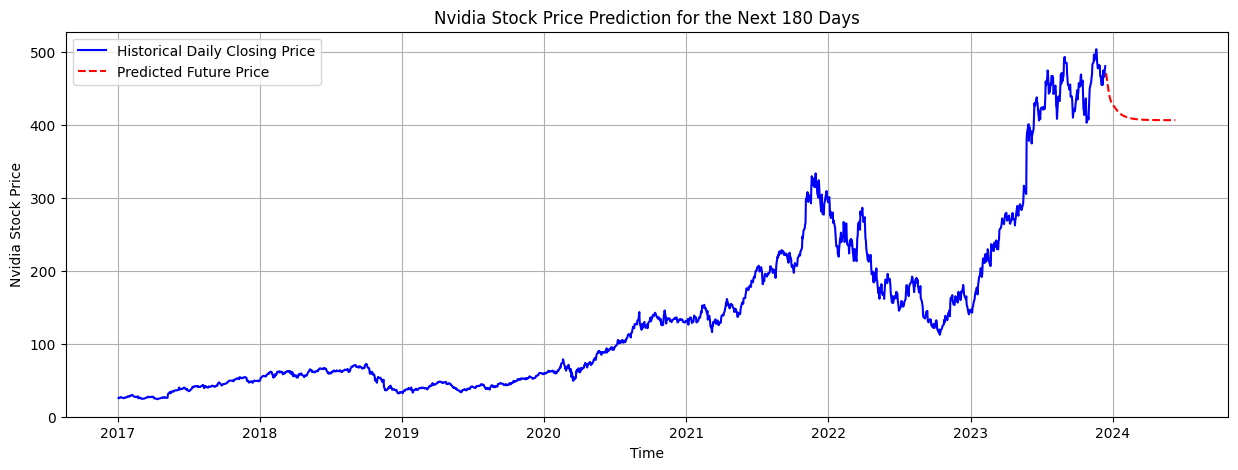

In [ ]:
# Plotting historical and predicted Nvidia stock prices
predicted_dates = pd.date_range(start=df.index[-1], periods=days_to_predict + 1, closed='right')
plt.figure(figsize=(15,5))
plt.plot(df.index, df['Close'], color='blue', label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price',linestyle='dashed')
plt.title(f'Nvidia Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('Nvidia Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('Future Prediction.png')
plt.show()